In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import preprocessing 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# plt.style.use('ggplot')#  fivethirtyeight
plt.style.use('seaborn')

import nltk
from nltk import sent_tokenize,word_tokenize 
from nltk.corpus import PlaintextCorpusReader
from wordcloud import WordCloud, STOPWORDS
    
import gensim.summarization
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities

from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint

import warnings
warnings.filterwarnings('ignore')

import folium
from folium.plugins import HeatMap
import webbrowser

In [2]:
df = pd.read_csv('02_FINAL_alldata.csv')
df.head(2)

,name,category,city,latitude,longitude,price_level,rating,review_count,delivery,pickup,...,distance,id,image_url,is_closed,location,phone,price,transactions,url,reviews
0,Upstate,"['Seafood', 'Wine Bars', 'Beer Bar']",New York,40.726314,-73.98649,2,4.5,1699,0,0,...,2411.918718,ehUuSk5gPTCQmwS_ubgKRA,https://s3-media1.fl.yelpcdn.com/bphoto/RvnUVU...,False,"{'address1': '95 1st Ave', 'address2': '', 'ad...",1.646792e+10,$$,['restaurant_reservation'],https://www.yelp.com/biz/upstate-new-york-2?ad...,"[""I've been meaning to try this place out for ..."
1,Amélie,"['French', 'Wine Bars']",New York,40.732700,-73.99766,2,4.5,2428,0,0,...,3038.869903,ETgJqJHV7BW6pIr9Ox74sA,https://s3-media4.fl.yelpcdn.com/bphoto/cSDgVu...,False,"{'address1': '22 W 8th St', 'address2': '', 'a...",1.212533e+10,$$,['restaurant_reservation'],https://www.yelp.com/biz/am%C3%A9lie-new-york?...,"[""I'm a huge fan of Amelie, and have been goin..."


For each Michelin restaurant, compare its review with all other non_Mi restaurants, get the top 50 most similar non-Mi restaurants

Get the number of similarity result of each non-Mi as the Similarity Score.

1. Get specific 209 Michelin reviews

### Recognize Michelins

In [3]:
mi_df = pd.read_excel('01_Get_Michelin_List.xlsx')
michelin_name = mi_df['name'].tolist()
michelin_city = mi_df['city'].tolist()

def is_Michelin(name,city, michelin_name, michelin_city):
    if name in michelin_name:
        idx = michelin_name.index(name)
        if city[0] ==  michelin_city[idx][0]: return 1
    return 0
    
df['is_Michelin'] = df[['name','city']].apply(lambda df: is_Michelin(df['name'],df['city'],michelin_name, michelin_city),axis=1)
df#.head(2)

,name,category,city,latitude,longitude,price_level,rating,review_count,delivery,pickup,...,id,image_url,is_closed,location,phone,price,transactions,url,reviews,is_Michelin
0,Upstate,"['Seafood', 'Wine Bars', 'Beer Bar']",New York,40.726314,-73.986490,2,4.5,1699,0,0,...,ehUuSk5gPTCQmwS_ubgKRA,https://s3-media1.fl.yelpcdn.com/bphoto/RvnUVU...,False,"{'address1': '95 1st Ave', 'address2': '', 'ad...",1.646792e+10,$$,['restaurant_reservation'],https://www.yelp.com/biz/upstate-new-york-2?ad...,"[""I've been meaning to try this place out for ...",0
1,Amélie,"['French', 'Wine Bars']",New York,40.732700,-73.997660,2,4.5,2428,0,0,...,ETgJqJHV7BW6pIr9Ox74sA,https://s3-media4.fl.yelpcdn.com/bphoto/cSDgVu...,False,"{'address1': '22 W 8th St', 'address2': '', 'a...",1.212533e+10,$$,['restaurant_reservation'],https://www.yelp.com/biz/am%C3%A9lie-new-york?...,"[""I'm a huge fan of Amelie, and have been goin...",0
2,Uglyduckling,"['American (Traditional)', 'Gastropubs']",New York,40.686023,-73.991302,2,4.0,432,1,1,...,CwOAKJdX8AMz5iAoA-ZEuA,https://s3-media2.fl.yelpcdn.com/bphoto/vyH8WZ...,False,"{'address1': '166 Smith St', 'address2': '', '...",1.718451e+10,$$,"['pickup', 'delivery', 'restaurant_reservation']",https://www.yelp.com/biz/uglyduckling-brooklyn...,"[""I've been meaning to try this place and fina...",0
3,Aunt Jake's,"['Italian', 'Wine Bars', 'Pasta Shops']",New York,40.719031,-73.997716,2,4.0,1143,1,1,...,I2lgw_7DUnwD92ND4PN-Ow,https://s3-media2.fl.yelpcdn.com/bphoto/hMhn_l...,False,"{'address1': '149 Mulberry St', 'address2': No...",1.646858e+10,$$,"['pickup', 'delivery', 'restaurant_reservation']",https://www.yelp.com/biz/aunt-jakes-new-york?a...,"[""This probably the best place to eat pasta in...",0
4,LoveMama,"['Thai', 'Malaysian', 'Vietnamese']",New York,40.730386,-73.986061,2,4.0,4136,1,1,...,jjJc_CrkB2HodEinB6cWww,https://s3-media1.fl.yelpcdn.com/bphoto/bLlFKT...,False,"{'address1': '174 2nd Ave', 'address2': '', 'a...",1.212255e+10,$$,"['pickup', 'delivery', 'restaurant_reservation']",https://www.yelp.com/biz/lovemama-new-york?adj...,"['Unbelievable food, gotta say. We had 6 apps ...",0
5,Joe's Shanghai,"['Shanghainese', 'Seafood']",New York,40.714669,-73.997760,2,4.0,5686,0,0,...,0CjK3esfpFcxIopebzjFxA,https://s3-media3.fl.yelpcdn.com/bphoto/ekUo5e...,False,"{'address1': '9 Pell St', 'address2': '', 'add...",1.212234e+10,$$,[],https://www.yelp.com/biz/joes-shanghai-new-yor...,['My favorite dumpling place in Manhattan.\n\n...,0
6,Jacob's Pickles,"['Comfort Food', 'Southern', 'American (Tradit...",New York,40.786650,-73.975528,2,4.0,3632,0,0,...,xt4sa64WOrpJvZBDPNPNYg,https://s3-media2.fl.yelpcdn.com/bphoto/167Rl2...,False,"{'address1': '509 Amsterdam Ave', 'address2': ...",1.212471e+10,$$,[],https://www.yelp.com/biz/jacobs-pickles-new-yo...,"[""If you want beer on tap, they have 25 differ...",0
7,Boucherie West Village,"['French', 'Cocktail Bars', 'Steakhouses']",New York,40.733063,-74.002877,3,4.5,989,1,1,...,s3jou_L_LVYGkNHiuhjlew,https://s3-media2.fl.yelpcdn.com/bphoto/-5TXMV...,False,"{'address1': '99 7th Ave S', 'address2': '', '...",1.212837e+10,$$$,"['pickup', 'delivery', 'restaurant_reservation']",https://www.yelp.com/biz/boucherie-west-villag...,"[""Went here for brunch on Saturday! \n\nOnce I...",0
8,Burger & Lobster,"['Seafood', 'Burgers', 'American (New)']",New York,40.740070,-73.993440,2,4.0,5002,1,1,...,UA2M9QFZghe-9th2KwLoWQ,https://s3-media3.fl.yelpcdn.com/bphoto/1rHd7F...,False,"{'address1': '39 W 19th St', 'address2': '', '...",1.646834e+10,$$,"['restaurant_reservation', 'pickup', 'delivery']",https://www.yelp.com/biz/burger-and-lobster-ne...,"[""Third time is the charm. We've had reservati...",0
9,Root & Bone,"['Southern', 'Comfort Food', 'Desserts']",New York,40.722720,-73.983340,2,4.0,1474,1,1,...,ULt3kmA0_hbZ3j6cMORCaA,https://s3-media2.fl.yelpcdn.com/bphoto/2WM96Q...,False,"{'address1': '200 E 3rd St', 'address2': '', '...",1.646683e+10,$$,"['pickup', 'delivery']",https://www.yelp.com/biz/root-and-b

####   Identify if there is a difference between Mi and non-Mi reviews
### 1. For each restaurant from all reviews, find its TOP 50 most similar Michelin Restaurants, and Calculate the Avg. Similarity score 

In [214]:
def get_corpus(review_list):    
    texts = [[word for word in document.lower().split() 
            if word not in STOPWORDS and word not in ['food','restaurant','place','come','came'] and word.isalnum() and len(word)>3]
            for document in review_list]
        
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]   # Frequency of each word in each text
    
    return dictionary, corpus

all_reviews = df['reviews'].tolist()
mi_reviews = df[df['is_Michelin']==1]['reviews'].tolist()
nonmi_reviews =df[df['is_Michelin']==0]['reviews'].tolist()

dictionary_all, corpus_all = get_corpus(all_reviews)
dictionary_mi, corpus_mi = get_corpus(mi_reviews)
dictionary_nonmi, corpus_nonmi = get_corpus(nonmi_reviews)

lsi = models.LsiModel(corpus_mi, id2word=dictionary_mi, num_topics=30)

In [569]:
def get_similar_score(doc,dictionary, corpus, top=50):
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]
    index = similarities.MatrixSimilarity(lsi[corpus])
    sims = index[vec_lsi]
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    score = sum([i[1] for i in sims[1:top+1]])/top   # 30
    
    return score

In [570]:
df['sims_score'] = df['reviews'].apply(lambda doc: get_similar_score(doc,dictionary_mi, corpus_mi,top=50))
# df['sims_score_2'] =  df['reviews'].apply(lambda doc: get_similar_score(doc,dictionary_mi, corpus_mi,top=100))  # top 2-101

#### Visualize the Difference of Similarities between Mi and non-Mi

Average Score of Michelins:     0.8565242781598591
Average Score of non-Michelins: 0.8099590843650037


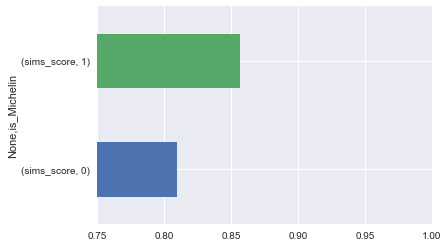

In [163]:
sims_diff = df[['is_Michelin','sims_score']]

diff = sims_diff.groupby('is_Michelin')
plt.xlim(0.75,1)
diff.mean().unstack().plot(kind='barh',figsize=(6,4))
print('Average Score of Michelins:    ',df[df['is_Michelin']==1]['sims_score'].mean()) #0.8659048675217672
print('Average Score of non-Michelins:',df[df['is_Michelin']==0]['sims_score'].mean()) #0.8251648988253718

(0.75, 1)

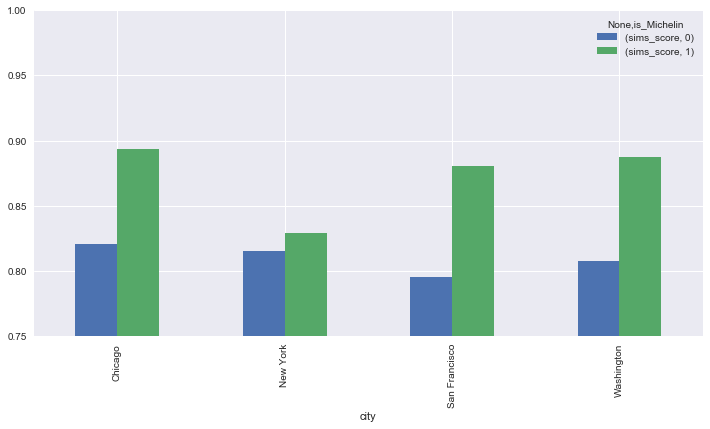

In [169]:
sims_diff = df[['is_Michelin','sims_score','city']]
diff = sims_diff.groupby(['city','is_Michelin'])

diff.mean().unstack().plot(kind='bar',figsize=(12,6))
plt.ylim(0.75,1)

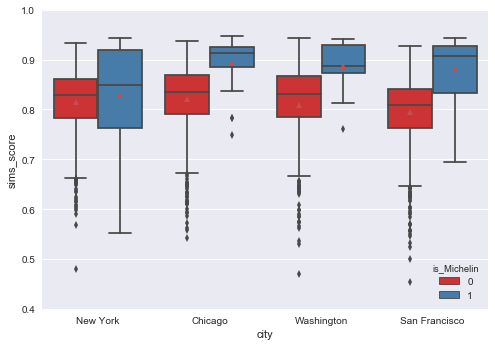

In [165]:
ax = sns.boxplot(x="city", y="sims_score", hue="is_Michelin",data=df,palette="Set1",showmeans=True)
plt.ylim(0.4,1)
plt.show()

### 2. For each Michelin restaurants, find the corresponding top most-similar non-Mi restaurants
#### For each restaurant, calculate its frequency of being nominated as the most like Michelin ones, save as 'Mi_nomi_score'

In [573]:
lsi = models.LsiModel(corpus_all, id2word=dictionary_all, num_topics=30)

def get_nomination_index(doc,dictionary, corpus): 
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]
    index = similarities.MatrixSimilarity(lsi[corpus])
    sims = index[vec_lsi]
    sims = sorted(enumerate(sims), key=lambda item: -item[1])[1:]

    nomination_index = [i[0] for i in sims[:100] if i[1] > 0.9]
    return nomination_index

mi_df = df[df['is_Michelin']==1]
nomination_list = []
for doc in mi_df['reviews']:
    nomination = get_nomination_index(doc,dictionary_all, corpus_all)
    nomination_list.extend(nomination)

In [588]:
nomination_dict = Counter(nomination_list)
sort_dict = sorted(nomination_dict.items())

nomination_score = []; n=0

for i in range(len(df)):
    idx = sort_dict[n][0]
    if i==idx: score = sort_dict[n][1]; n+=1
    else: score=0
    nomination_score.append(score)
    
nomination_score_scaled = preprocessing.scale(nomination_score)
df['Mi_nomi_score'] = pd.Series(nomination_score)
df['Mi_nomi_score_scale'] = pd.Series(nomination_score_scaled)
df.head()

,name,category,city,latitude,longitude,price_level,rating,review_count,delivery,pickup,...,location,phone,price,transactions,url,reviews,is_Michelin,sims_score,Mi_nomi_score,Mi_nomi_score_scale
0,Upstate,"['Seafood', 'Wine Bars', 'Beer Bar']",New York,40.726314,-73.986490,2,4.5,1699,0,0,...,"{'address1': '95 1st Ave', 'address2': '', 'ad...",1.646792e+10,$$,['restaurant_reservation'],https://www.yelp.com/biz/upstate-new-york-2?ad...,"[""I've been meaning to try this place out for ...",0,0.861696,0,-0.295924
1,Amélie,"['French', 'Wine Bars']",New York,40.732700,-73.997660,2,4.5,2428,0,0,...,"{'address1': '22 W 8th St', 'address2': '', 'a...",1.212533e+10,$$,['restaurant_reservation'],https://www.yelp.com/biz/am%C3%A9lie-new-york?...,"[""I'm a huge fan of Amelie, and have been goin...",0,0.862427,0,-0.295924
2,Uglyduckling,"['American (Traditional)', 'Gastropubs']",New York,40.686023,-73.991302,2,4.0,432,1,1,...,"{'address1': '166 Smith St', 'address2': '', '...",1.718451e+10,$$,"['pickup', 'delivery', 'restaurant_reservation']",https://www.yelp.com/biz/uglyduckling-brooklyn...,"[""I've been meaning to try this place and fina...",0,0.788418,2,-0.168388
3,Aunt Jake's,"['Italian', 'Wine Bars', 'Pasta Shops']",New York,40.719031,-73.997716,2,4.0,1143,1,1,...,"{'address1': '149 Mulberry St', 'address2': No...",1.646858e+10,$$,"['pickup', 'delivery', 'restaurant_reservation']",https://www.yelp.com/biz/aunt-jakes-new-york?a...,"[""This probably the best place to eat pasta in...",0,0.812955,1,-0.232156
4,LoveMama,"['Thai', 'Malaysian', 'Vietnamese']",New York,40.730386,-73.986061,2,4.0,4136,1,1,...,"{'address1': '174 2nd Ave', 'address2': '', 'a...",1.212255e+10,$$,"['pickup', 'delivery', 'restaurant_reservation']",https://www.yelp.com/biz/lovemama-new-york?adj...,"['Unbelievable food, gotta say. We had 6 apps ...",0,0.755836,5,0.022916


In [9]:
# df.to_csv('04_FINAL_LSI_LDA.csv',index=False)

### To avoiding re-run the above codes which cost a long time, we save the updated dataset for the following part.  

In [10]:
df = pd.read_csv('04_FINAL_LSI_LDA.csv')

Average Scaled Score of Michelins:     3.4326356069853166
Average Scaled Score of non-Michelins: -0.1472750647929848


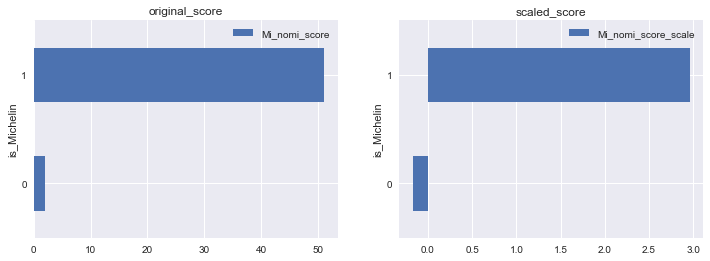

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

ax = axes[0]
diff = df[['is_Michelin','Mi_nomi_score']].groupby('is_Michelin')
diff.mean().plot(kind='barh',ax=ax)
ax.set_title('original_score')

ax = axes[1]
diff_scale = df[['is_Michelin','Mi_nomi_score_scale']].groupby('is_Michelin')
diff_scale.mean().plot(kind='barh',ax=ax)
ax.set_title('scaled_score')

print('Average Scaled Score of Michelins:    ',df[(df['is_Michelin']==1) & (df['city']=='Washington')]['Mi_nomi_score_scale'].mean())
print('Average Scaled Score of non-Michelins:',df[(df['is_Michelin']==0) & (df['city']=='Washington')]['Mi_nomi_score_scale'].mean())

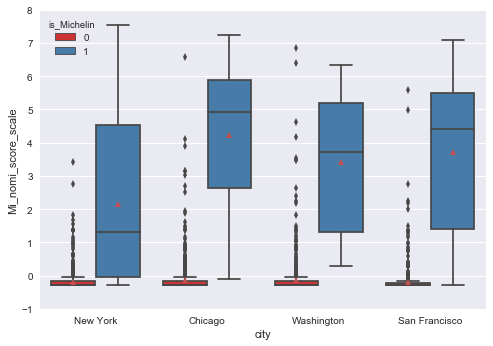

In [170]:
ax = sns.boxplot(x="city", y="Mi_nomi_score_scale", hue="is_Michelin",data=df,palette="Set1",showmeans=True)
plt.ylim(-1,8)
plt.show()

### 3. Since there are differences between Mi & non-Mi reviews. The differences maybe...about Topic

In [215]:
lda_mi = LdaModel(corpus_mi,id2word=dictionary_mi, num_topics=5, passes=5)  # top 3 

In [221]:
lda_nonmi = LdaModel(corpus_nonmi,id2word=dictionary_nonmi, num_topics=7, passes=3)  # top 5

In [201]:
def draw_wordcloud(lda,topicnum,min_size=4,STOPWORDS=['like','place']):
    word_list=[]
    prob_total = 0
    for word,prob in lda.show_topic(topicnum,topn=200): prob_total +=prob
    for word,prob in lda.show_topic(topicnum,topn=200):
        if word in STOPWORDS or len(word) < min_size: continue
        freq = int(prob/prob_total*1000)
        alist=[word]
        word_list.extend(alist*freq)

    from random import shuffle
    shuffle(word_list)
    text = ' '.join(word_list)

    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',max_words=250,width=1200,height=800,max_font_size=200).generate(text)  # ,width=9000,height=3000
    return wordcloud

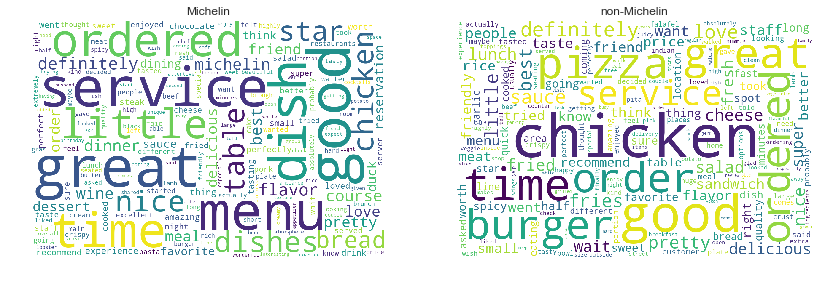

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

ax = axes[0]
wordcloud = draw_wordcloud(lda_mi,topicnum=3,min_size=4)
ax.imshow(wordcloud)
ax.axis('off')
ax.set_title('Michelin')

ax = axes[1]
wordcloud = draw_wordcloud(lda_nonmi,topicnum=5,min_size=4)
ax.imshow(wordcloud)
ax.axis('off')
ax.set_title('non-Michelin')
plt.show()

#### Mi: polarity words 'definitely', 'menu', 'course/dish', 'service', 'experience' —> decent
#### non-Mi: more specific styles, 'time', 'brunch', 'friend' —> casual

In [217]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda_mi, corpus_mi, dictionary_mi, sort_topics=False)

pyLDAvis.save_html(lda_display,'lda_display_mi1.html')
webbrowser.open('lda_display_mi1.html')
pyLDAvis.display(lda_display)

In [223]:
lda_display2 = pyLDAvis.gensim.prepare(lda_nonmi, corpus_nonmi, dictionary_nonmi, sort_topics=False)

pyLDAvis.save_html(lda_display2,'lda_display_nonmi1.html')
webbrowser.open('lda_display_nonmi1.html')
pyLDAvis.display(lda_display2)

In [3]:
pre_ny = df[(df['is_Michelin']==0) & (df['city']=='New York')][['name','Mi_nomi_score_scale']]
pre_ca = df[(df['is_Michelin']==0) & (df['city']=='Chicago')][['name','Mi_nomi_score_scale']]
pre_dc = df[(df['is_Michelin']==0) & (df['city']=='Washington')][['name','Mi_nomi_score_scale']]
pre_sf = df[(df['is_Michelin']==0) & (df['city']=='San Francisco')][['name','Mi_nomi_score_scale']]

In [8]:
def get_potentials(df,top=10):
    potent=[]
    for i in df.index:
        potent.append([df['Mi_nomi_score_scale'][i],df['name'][i]])
    potential_list = sorted(potent, key=lambda item: -item[0])[:top]
    return potential_list

pd.DataFrame(get_potentials(pre_dc,top=20))

,0,1
0,6.846106,Gravitas
1,6.399729,Marcel's by Robert Wiedmaier
2,4.614221,Corduroy
3,4.167845,1789 Restaurant
4,3.530163,A Rake's Progress
5,3.466395,Honeysuckle
6,3.466395,Elizabeth's Gone Raw
7,2.637410,Obelisk
8,2.382337,Le Desales
9,2.254801,Del Mar


### Visualization

In [2]:
from folium.plugins import HeatMap
import pandas as pd
df = pd.read_csv('FINAL+sims2.csv')
# df.head()

In [79]:
loc_ny = df[(df['is_Michelin']==1) & (df['city']=='New York')][['name','latitude','longitude']]
loc_ca = df[(df['is_Michelin']==1) & (df['city']=='Chicago')][['name','latitude','longitude']]
loc_dc = df[(df['is_Michelin']==1) & (df['city']=='Washington')][['name','latitude','longitude']]
loc_sf = df[(df['is_Michelin']==1) & (df['city']=='San Francisco')][['name','latitude','longitude']]

In [80]:
loc_ny_non = df[(df['is_Michelin']==0) & (df['city']=='New York')][['latitude','longitude']].dropna()
loc_ca_non = df[(df['is_Michelin']==0) & (df['city']=='Chicago')][['latitude','longitude']].dropna()
loc_dc_non = df[(df['is_Michelin']==0) & (df['city']=='Washington')][['latitude','longitude']].dropna()
loc_sf_non = df[(df['is_Michelin']==0) & (df['city']=='San Francisco')][['latitude','longitude']].dropna()

In [84]:
heat_obj_ny=[[loc_ny_non['latitude'][i],loc_ny_non['longitude'][i]] for i in loc_ny_non.index]

m_ny = folium.Map(location = [loc_ny_non['latitude'].mean(),loc_ny_non['longitude'].mean()],zoom_start=14)

HeatMap(heat_obj_ny).add_to(m_ny)

for i in loc_ny.index: 
    folium.RegularPolygonMarker([loc_ny['latitude'][i],loc_ny['longitude'][i]], popup = loc_ny['name'][i], fill_color='blue', number_of_sides=3, radius=6).add_to(m_ny)
    
m_ny.save('m_ny.html')
webbrowser.open('m_ny.html')

m_ny

In [86]:
heat_obj_ca=[[loc_ca_non['latitude'][i],loc_ca_non['longitude'][i]] for i in loc_ca_non.index]

m_ca = folium.Map(location = [loc_ca_non['latitude'].mean(),loc_ca_non['longitude'].mean()],zoom_start=12)

HeatMap(heat_obj_ca).add_to(m_ca)

for i in loc_ca.index: 
    folium.RegularPolygonMarker([loc_ca['latitude'][i],loc_ca['longitude'][i]], popup = loc_ca['name'][i], fill_color='blue', number_of_sides=3, radius=6).add_to(m_ca)
    
m_ca.save('m_ca.html')
webbrowser.open('m_ca.html')

m_ca

In [88]:
heat_obj_dc=[[loc_dc_non['latitude'][i],loc_dc_non['longitude'][i]] for i in loc_dc_non.index]

m_dc = folium.Map(location = [loc_dc_non['latitude'].mean(),loc_dc_non['longitude'].mean()],zoom_start=14)

HeatMap(heat_obj_dc).add_to(m_dc)

for i in loc_dc.index: 
    folium.RegularPolygonMarker([loc_dc['latitude'][i],loc_dc['longitude'][i]], 
                                popup = loc_dc['name'][i], fill_color='blue', number_of_sides=3, radius=6).add_to(m_dc)
    
m_dc.save('m_dc.html')
webbrowser.open('m_dc.html')

m_dc

In [89]:
heat_obj_sf=[[loc_sf_non['latitude'][i],loc_sf_non['longitude'][i]] for i in loc_sf_non.index]

m_sf = folium.Map(location = [loc_sf_non['latitude'].mean(),loc_sf_non['longitude'].mean()],zoom_start=12)

HeatMap(heat_obj_sf).add_to(m_sf)

for i in loc_sf.index: 
    folium.RegularPolygonMarker([loc_sf['latitude'][i],loc_sf['longitude'][i]], 
                                popup = loc_sf['name'][i], fill_color='blue', number_of_sides=3, radius=6).add_to(m_sf)
    
m_sf.save('m_sf.html')
webbrowser.open('m_sf.html')

m_sf